<img src="PUBG-banner-1.png">

# What is PlayerUnknown's BattleGrounds (PUBG) ?

### - A battle to the <font color=red>last player standing</font>, with 100 players on an island 
### - Start with nothing and have to scavenge and collect weapons and medical supplies
### - Three modes of play: Solo, Duo and Squad

<img src="WechatIMG554.jpeg" width="80%" align='left'/>

# Sounds Interesting, BUT... a lot of Cheaters!

### - Exploit game bugs to  <font color=red>have way-above-average performance</font> over other players
- Collect 100 weapons without moving
- Kill 100 people
- Revive 100 times
- Run 100m/second

### - Disrupt game balance: The true skilled cannot win!
### - A huge problem since the release of PUBG
- PUBG has banned **13 Million** cheaters!
- **120 people** has been arrested due to developing cheating plugins
- Fines are over **$5.1 Million**

# So...Let's hunt cheaters down!

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import random
import warnings
warnings.filterwarnings("ignore")

In [3]:
#link of data
#https://www.kaggle.com/c/pubg-finish-placement-prediction/data
train = pd.read_csv('./data/train_V2.csv')

In [4]:
pd.options.display.max_columns = None
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [19]:
#Utility functions
def train_test_split(df, test_size=0.3):
    import random
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    return train, test

def outlier_range(var,perc,df):
    return np.percentile(df[var],perc)

def show_distplot(var,title):
    plt.figure(figsize=(10,8))
    sns.distplot(df[var],bins=50)
    plt.title(title,fontsize=15)
    plt.show()

In [6]:
#data cleaning and feature engineering part
df = train[(train['matchType'].isin(['solo','solo-fpp','duo','duo-fpp','squad','squad-fpp']))]

#number of player each match/each team
df['numJoined'] = df.groupby('matchId')['matchId'].transform('count')
df['teamNum'] = df.groupby('groupId')['groupId'].transform('count')

df['totalDistance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
df['headshotPerc'] = df['headshotKills']/df['kills']

#since each game has different num of players, needs to normalize
normalize = (100-df['numJoined'])/100 + 1
df['killsNorm'] = df['kills'] * normalize

df['killsPerDistance'] = df['killsNorm']/(df['totalDistance'] + 1e31)
df['weaponPerDistance'] = df['weaponsAcquired']/(df['totalDistance'] + 1e31)

#explore heals and boost
#allow you to stay out of zone longer
df['healsAndBoosts'] = df['heals'] + df['boosts']
df['healsAndBoostsPerWalkDistance'] = df['healsAndBoosts']/(df['walkDistance']+1e31)
df['healsAndBoostsPerKill'] = df['healsAndBoosts']/(df['killsNorm']+1e31)

#deal with inf and nan
df.replace([np.inf, -np.inf], np.nan)
df.fillna(0,inplace=True)

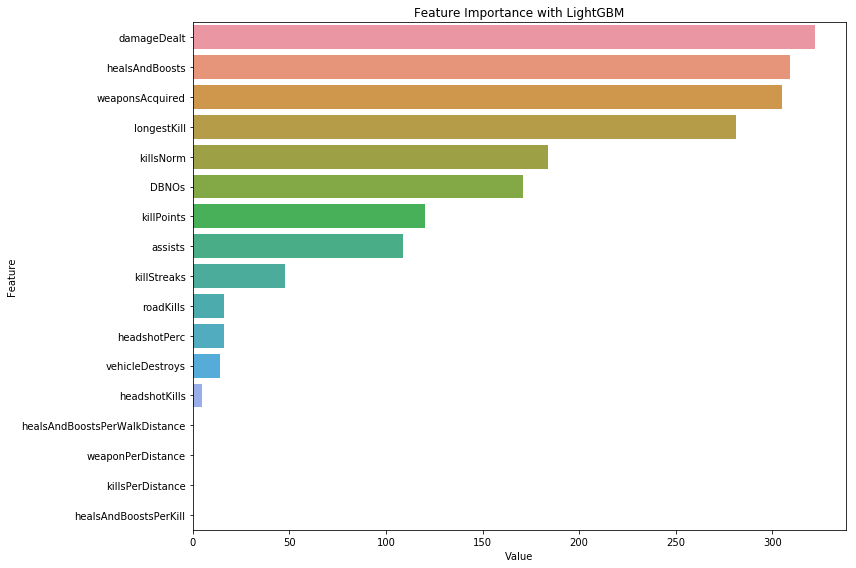

In [15]:
#feature importance using light GBM
target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target, 'killPlace','walkDistance','numJoined','teamNum',
               'matchDuration','kills','maxPlace','winPoints','boosts','heals','rideDistance','swimDistance',
               'rankPoints','revives','teamKills','numGroups','totalDistance']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
train, val = train_test_split(df, 0.3)

params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}

model = LGBMRegressor(**params)
model.fit(
    train[cols_to_fit], train[target],
    eval_set=[(val[cols_to_fit], val[target])],
    eval_metric='mae',
    verbose=-1,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('Feature Importance with LightGBM')
plt.tight_layout()

# What are some important features to assess cheaters?

### - Normalized Kills (according to number of players joined the match)
### - Headshot Percentage
### - RoadKills
### - Weapons acquired per distance
### - Medical supplies per kill

# How is everyone doing in PUBG?

## <font color=darkcyan>Kills -- Massacre?</font>

In [37]:
random.seed(831)

plotly.tools.set_credentials_file(username='jhuo831alex', api_key='hIejbAalxmsP4IlYnSaS')
data,test = train_test_split(df,0.99)
data = data[['killsNorm','winPlacePerc']]
data['killsNorm'] = data['killsNorm'].astype('int')
N = 30
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]
kill_num = list(set(data['killsNorm']))
graph_data = [{
    'y': data['winPlacePerc'].loc[data['killsNorm']==kill_num[i]],
    'name':kill_num[i],
    'type':'box',
    'marker':{'color': c[i]}
} for i in range(len(kill_num))]

layout = {'xaxis': {'showgrid':True,'zeroline':False, 'tickangle':60,'showticklabels':True,'title':'Number of Kills'},
          'yaxis': {'zeroline':False,'gridcolor':'white','title':'Rank Percentile'},
          #'paper_bgcolor': 'rgb(233,233,233)',
          #'plot_bgcolor': 'rgb(233,233,233)',
          'title': 'Kills vs. Final Rank Percentile'
          }
fig = go.Figure(data=graph_data,layout=layout)
py.iplot(fig)

In [38]:
non_killing_perc = round(len(df[df['killsNorm']==0])/len(df) * 100,2)
two_killing_perc = round(len(df[df['killsNorm']<=2])/len(df) * 100,2)
max_kill = int(max(df['killsNorm']))
outlier_kill = outlier_range('killsNorm',99,df)

# print(non_killing_perc)
# print(two_killing_perc)
# print(max_kill)
# print(outlier_kill)

### 56.98% of players did not kill a single enemy!
### 78.22% of players killed less than 3 enemies.
### But...One player killed <font color=red>34</font> people in a game?! Sounds suspicious ummmm...
### So if one player killed more than 99% of other players do, we assume this individual could be possibly cheating.

## <font color=darkcyan>Incredible Head Shooters?</font>

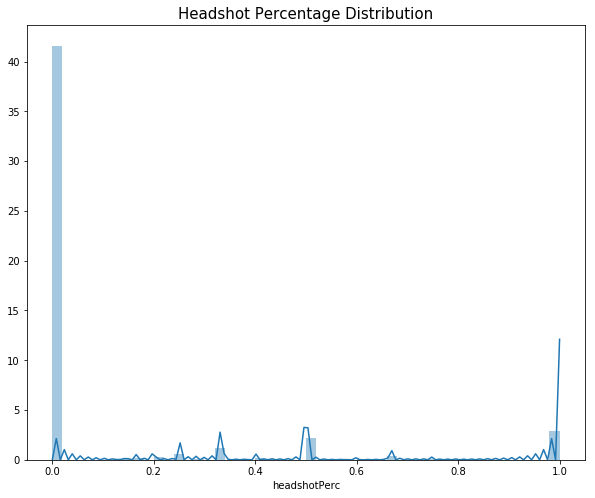

In [83]:
show_distplot('headshotPerc','Headshot Percentage Distribution')

In [85]:
max_headshot = df['kills'][df['headshotPerc']==1].max()
#print(max_headshot)

### Has 100% headshot rate shows you are a good player.
### Yet...killing 15 people all by headshots? Too good to be true! Could be cheaters.

##  <font color=darkcyan>Experienced Drivers or Cheaters?</font>

In [56]:
df[['Id','roadKills','kills','winPlacePerc']].sort_values('roadKills').tail(3)

,Id,roadKills,kills,winPlacePerc
2767999,34193085975338,11,11,0.4713
2733926,c3e444f7d1289f,14,14,0.4286
2890740,a3438934e3e535,18,20,1.0000


In [50]:
has_roadkill = round(100 - len(df[df['roadKills']==0])/len(df) * 100,2)
max_roadkill = int(max(df['roadKills']))

### Only 0.26% of players had crashed over enemies using vehicles.
### One player ran over <font color=red>18</font> enemies with his/her car!! This is insane!!
### Once again, if one player kills absurdly many enemies by car, we assume this individual could be a cheater. 

##  <font color=darkcyan>Weapon Magnets?</font>

In [39]:
hover_text,bubble_size = [], []
data,test = train_test_split(df,0.9999)
data['is_team'] = np.where(data['matchType'].isin(['solo','solo-fpp']),'solo',
                         np.where(data['matchType'].isin(['duo','duo-fpp']),'duo','squad'))
for index, row in data.iterrows():
    hover_text.append(('Match Type: {is_team}<br>'+
                      'Rank Percentile: {winPlacePerc}<br>'+
                      'Total Distance Traveled: {totalDistance}<br>'+
                      'Weapons Acquired: {weaponsAcquired}<br>').format(is_team=row['is_team'],
                                            winPlacePerc=row['winPlacePerc'],
                                            totalDistance=row['totalDistance'],
                                            weaponsAcquired=row['weaponsAcquired']))
    bubble_size.append(row['weaponsAcquired'] * 500)
data['text'] = hover_text
data['size'] = bubble_size
sizeref = data['weaponsAcquired'].max()

match_types = list(set(data['is_team']))
graph_data = list()

for match_type in match_types:
    trace = go.Scatter(
                x=data['totalDistance'][data['is_team'] == match_type],
                y=data['winPlacePerc'][data['is_team'] == match_type ],
                mode='markers',
                name=match_type,
                text=data['text'][data['is_team'] == match_type],
                marker=dict(
                    symbol='circle',
                    sizemode='area',
                    sizeref=sizeref,
                    size=data['size'][data['is_team'] == match_type],
                    line=dict(
                        width=2
                    ),
                )
            )
    graph_data.append(trace)

layout = go.Layout(
    title='Rank Percentile based on Weapons acquired per Distance',
    xaxis=dict(
        title='Total Distance Traveled',
        gridcolor='rgb(255, 255, 255)',
        range=[0, max(data['totalDistance'])],
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Rank Percentile',
        gridcolor='rgb(255, 255, 255)',
        range=[0, 1.05],
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
)

fig = go.Figure(data=graph_data, layout=layout)
py.iplot(fig)

In [26]:
outlier_weapon = round(len(df[(df['weaponsAcquired'] > 10) & (df['totalDistance'] == 0)])/len(df) * 100,2)
max_weapon = df[df['totalDistance']==0]['weaponsAcquired'].max()

# print(outlier_weapon)
# print(max_weapon)

### Typically, you wander around to gather weapons.
### Yet, 0.01% of players collect more than 10 weapons without moving. Interesting...
### One player acquired <font color=red>52</font> weapons without moving a single meter!
### We assume this kind of "Weapon Magnets" to be cheaters.

## <font color=darkcyan>Deadpools?</font>

In [40]:
hover_text = []
data,test = train_test_split(df,0.99)
for index, row in data.iterrows():
    hover_text.append(('Number of Kills: {killsNorm}<br>'+
                      'Heals and Boosts: {healsAndBoosts}<br>'+
                      'Rank Percentile: {winPlacePerc}<br>').format(killsNorm=row['killsNorm'],
                                            healsAndBoosts=row['healsAndBoosts'],
                                            winPlacePerc=row['winPlacePerc']))
data['text'] = hover_text
trace1 = go.Scatter3d(
    x=data['killsNorm'],
    y=data['healsAndBoosts'],
    z=data['winPlacePerc'],
    mode='markers',
    text = data['text'],
    marker=dict(
        size=5,
        color = 'pink',
        line = dict(color='lightblue', width = 0.5),
        colorscale='Jet', 
        opacity=0.8
    )
)
graph_data = [trace1]
layout = go.Layout(
    title='Number of Kills v. Medical Supplies v. Rank Percentile',
    autosize=False,
    scene=go.Scene(
        xaxis=go.XAxis(title='Number of Kills'),
        yaxis=go.YAxis(title='Heals and Boosts'),
        zaxis=go.ZAxis(title='Rank Percentile')),
     margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)

fig = go.Figure(data=graph_data, layout=layout)
py.iplot(fig)

### Not using medical supplies is normal, 
### But...Killing over <font color=red>10</font> people without healing, are they deadpools or cheaters??

In [28]:
df[['healsAndBoosts','kills','winPlacePerc']][df['healsAndBoosts']==0].sort_values('kills').tail(3)

,healsAndBoosts,kills,winPlacePerc
652889,0,16,1.0
2033134,0,17,1.0
3517965,0,17,1.0


In [41]:
#subset the data from 4 million to 0.1 million to save computation time
#use the above assumptions to find out the cheaters in this 0.1 million data
data_sub,try_ = train_test_split(df,0.977)

id_set = set()
id_set.update(data_sub['Id'].loc[data_sub['killsNorm'] >= np.percentile(data_sub['killsNorm'],99)])
id_set.update(data_sub[data_sub['roadKills']>=int(outlier_range('roadKills',99.9,data_sub))]['Id'])
id_set.update(data_sub[(data_sub['weaponsAcquired'] > outlier_range('weaponsAcquired',99,data_sub)) & (data_sub['totalDistance'] == 0)]['Id'])
id_set.update(data_sub[(data_sub['headshotPerc']==1)&(data_sub['killsNorm']>outlier_range('killsNorm',99,data_sub))]['Id'])
id_set.update(data_sub[(data_sub['healsAndBoosts']==0)&(data_sub['killsNorm'] > outlier_range('killsNorm',99,data_sub))]['Id'])

In [43]:
outlier_len = len(set(id_set))
#print(outlier_len)

### According to our assumptions above, we found <font color=red>1329</font> potential cheaters out of 0.1 million players.
### Is there any faster way to catch cheaters? Yes! 

# Machine Learning: Anomaly Detection

## <font color=darkcyan>One-Class Support Vector Machine (OCSVM)</font>

In [60]:
#data preparation
data = data_sub[['roadKills','killsNorm','weaponPerDistance','healsAndBoostsPerKill','headshotPerc']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

## PCA to speed-up ML algorithms

In [56]:
# PCA to speed-up machine learning algorithms
pca = PCA(n_components=5)
pca_data = pca.fit_transform(data)
print(pca.explained_variance_ratio_) #every component explains a part of data

[0.3855168  0.2003042  0.18627083 0.12983489 0.09807328]


## Decide the proportion of cheaters in games

In [62]:
outlier_lst = [0.01,0.05,0.1]

#find out proportion of cheaters in the games
for outliers_fraction in outlier_lst:
    model =  OneClassSVM(nu=0.95 * outliers_fraction,verbose=False) 
    model.fit(data)
    data_sub['anomaly_svm'] = model.predict(data)
    data_sub['anomaly_svm'] = data_sub['anomaly_svm'].map({1: 0, -1: 1})

    cheater_id = data_sub['Id'].loc[data_sub['anomaly_svm']==1]
    precision = round(len(set(cheater_id) & id_set) / len(id_set) * 100,2)
    
    print(f'Assumption: There are {str(outliers_fraction*100)}% of cheaters in the games:')
    print('Count of cheaters: 0 - Normal players, 1 - Cheaters')
    print(data_sub['anomaly_svm'].value_counts())
    print(f"""{str(precision)}% of the {str(outlier_len)} player we identified as cheaters using above assumptions and data visualization methods 
are also labeled as cheaters using the One-Class SVM model.\n""")

Assumption: There are 1.0% of cheaters in the games:
Count of cheaters: 0 - Normal players, 1 - Cheaters
0    95104
1     6776
Name: anomaly_svm, dtype: int64
29.65% of the 1329 player we identified as cheaters using above assumptions and data visualization methods 
are also labeled as cheaters using the One-Class SVM model.

Assumption: There are 5.0% of cheaters in the games:
Count of cheaters: 0 - Normal players, 1 - Cheaters
0    91019
1    10861
Name: anomaly_svm, dtype: int64
77.58% of the 1329 player we identified as cheaters using above assumptions and data visualization methods 
are also labeled as cheaters using the One-Class SVM model.

Assumption: There are 10.0% of cheaters in the games:
Count of cheaters: 0 - Normal players, 1 - Cheaters
0    88087
1    13793
Name: anomaly_svm, dtype: int64
98.87% of the 1329 player we identified as cheaters using above assumptions and data visualization methods 
are also labeled as cheaters using the One-Class SVM model.



## Cross Validating the model:

### When cheater proportion is 10%,  <font color=red>98.87%</font> of the 1329 players we identified as cheaters using above 
### assumptions and data visualization methods are also labeled as cheaters using the One-Class SVM model.
### <font color=orange>10% is a good estimation of proportion of cheaters in PUBG, and the model is actually identifying cheaters.</font>

## Try another method to cross validate... <font color=darkcyan>Isolation Forest</font>

In [63]:
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
data_sub['anomaly_if'] = model.predict(data)
data_sub['anomaly_if'] = data_sub['anomaly_if'].map( {1: 0, -1: 1} )
print(data_sub['anomaly_if'].value_counts())

0    91688
1    10192
Name: anomaly_if, dtype: int64


In [75]:
cheater_id2 = data_sub['Id'].loc[data_sub['anomaly_if']==1]
precision2 = round(len(set(cheater_id2) & id_set) / len(id_set) * 100,2)
#print(precision2)

###  <font color=red>91.27%</font> of the 1329 players we identified as cheaters using above assumptions and data visualization methods 
### are also labeled as cheaters, showing that Isolation Forest is also a good model to identify cheaters.

## Find the players identified by both models as cheaters

In [79]:
overlap_len = len(set(data_sub['Id'].loc[data_sub['anomaly_if']==1]) & set(data_sub['Id'].loc[data_sub['anomaly_svm']==1]))
min_len = min(len(data_sub['Id'].loc[data_sub['anomaly_if']==1]),len(data_sub['Id'].loc[data_sub['anomaly_svm']==1]))
overlap_coeff = round(overlap_len/min_len *100,2)
# print(overlap_len)
# print(overlap_coeff)

### 6563 players are labeled as cheaters by both SVM and Isolation Forest model. The overlap coefficient is 64.39%.
### After cross validation, we are now confident that these 6563 players are more likely to be cheaters.

# What we did to catch cheaters...

<img src="Conclusion.png" align='left'/>

<img src="cheater.jpg" width="60%" align='left'/>

# Proudly Presented by  <font color=gold>Team ChickenDinner</font>
# Thank you for listening! 